<a href="https://colab.research.google.com/github/honeyshi/NLP_Lab1/blob/main/NLP_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [54]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

import copy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

from string import punctuation

from collections import Counter

import keras
import keras.layers as L
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import LatentDirichletAllocation, PCA

from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap
import bokeh.models as bm, bokeh.plotting as pl

from wordcloud import WordCloud

import plotly.express as px

In [ ]:
pip install catboost

In [154]:
from catboost import CatBoostClassifier

In [ ]:
pip install pyLDAvis

In [ ]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

In [24]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [7]:
train = pd.read_parquet('/content/drive/My Drive/data/train.parquet')
train = train.reset_index()

## Exploratory Data Analysis

In [8]:
def remove_html_brackets(body):
  return body.replace("<", "").replace(">", " ").strip()

In [9]:
train['Tags'] = train['Tags'].apply(remove_html_brackets)

In [5]:
train.head()

Id  ... target
0  34862324  ...      2
1  47303682  ...      2
2  46431243  ...      0
3  45306324  ...      0
4  49479547  ...      1

[5 rows x 5 columns]

In [10]:
train['Tags_list'] = train['Tags'].apply(lambda x: x.split())
all_tags = [item for sublist in train['Tags_list'].values for item in sublist]

In [11]:
unique_tags = list(set(all_tags))

In [8]:
print("Length all tags: %d Length unique tags: %d" % (len(all_tags), len(unique_tags)))

Length all tags: 127809 Length unique tags: 9619


In [180]:
frequency_dict = nltk.FreqDist(all_tags)

most_common_words = frequency_dict.most_common(10)

In [132]:
words = [w[0] for w in most_common_words]
counts = [w[1] for w in most_common_words]
x_pos = np.arange(len(words)) 
    
plt.figure(2, figsize=(10, 10/1.6180))
plt.subplot(title='10 most common words')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [12]:
output_notebook()

In [13]:
average_length = {}
avergae_count = {}
count_quality = {}
for i, item in train.iterrows():
  for tag in item["Tags_list"]:
    avergae_count[tag] = avergae_count.get(tag, 0)+1
    average_length[tag] = average_length.get(tag, 0) + len(item["Body"])
    if tag not in count_quality:
      count_quality[tag] = []
    count_quality[tag].append(item["target"])
    


new_data = {}
for key in avergae_count:
  new_data[key] = {
      "avg_len": 0,
      "count": 0
  }  
  new_data[key]["avg_len"] = average_length[key]/avergae_count[key]
  new_data[key]["count"] = avergae_count[key]

In [14]:
avg_qua = pd.DataFrame({}, columns=['tag', '0', '1', '2', 'target_count'])
for item in count_quality:
  s={'tag': item,'0':0, '1':0, '2':0, 'target_count': 0}
  for i in count_quality[item]:
    s[str(i)]+=1
  s['target_count']=s['0']+s['1']+s['2']
  avg_qua= pd.concat([avg_qua, pd.DataFrame(s, index=[0])])
avg_qua=avg_qua.sort_values(by="target_count",ascending=0)

In [15]:
targets = ['0', '1', '2']
count = 30
data = {
    "target": targets,
    "0": [],
    "1": [],
    "2": []
}
for i, item in avg_qua[:count].iterrows():
  data[item["tag"]] = []
  data["0"].append(item["0"])
  data["1"].append(item["1"])
  data["2"].append(item["2"])
print(data)

x = [ (tag["tag"], target) for i, tag in avg_qua[:count].iterrows() for target in targets ]
counts = sum(zip(data["0"], data['1'], data['2']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=1600, title="–ö–æ–ª-–≤–æ –æ—Ü–µ–Ω–æ–∫ –¥–ª—è "+ str(count) +" —Å–∞–º—ã—Ö –≤—Å—Ç—Ä–µ—á–∞—é—â–∏—Ö—Å—è —Ç–µ–≥–æ–≤",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source,
       fill_color=factor_cmap('x', palette=Spectral5, factors=targets, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

show(p)

{'target': ['0', '1', '2'], '0': [1540, 1596, 849, 1368, 323, 595, 280, 458, 242, 113, 690, 118, 68, 67, 132, 469, 913, 203, 776, 226, 38, 56, 536, 51, 151, 564, 127, 21, 457, 44], '1': [2349, 2082, 2252, 966, 1815, 1455, 1296, 1199, 797, 700, 336, 666, 782, 318, 552, 361, 129, 415, 99, 434, 506, 125, 164, 404, 269, 60, 267, 99, 12, 213], '2': [1749, 1802, 1930, 1546, 1217, 1297, 1118, 730, 653, 655, 425, 664, 597, 935, 573, 422, 151, 477, 73, 254, 363, 673, 133, 343, 354, 55, 143, 386, 18, 211], 'javascript': [], 'python': [], 'java': [], 'android': [], 'php': [], 'c#': [], 'html': [], 'c++': [], 'css': [], 'arrays': [], 'ios': [], 'jquery': [], 'c': [], 'sql': [], 'mysql': [], 'swift': [], 'angular': [], 'python-3.x': [], 'reactjs': [], 'r': [], 'regex': [], 'sql-server': [], 'node.js': [], 'string': [], 'json': [], 'typescript': [], 'linux': [], 'excel': [], 'docker': [], 'list': []}


–°–∞–º–æ–µ –±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–æ–ø—Ä–æ—Å–æ–≤ —Å –≤—ã—Å–æ–∫–æ–π –æ—Ü–µ–Ω–∫–æ–π –∏–º–µ—é—Ç —Ç–µ–≥–∏, —Å–≤—è–∑–∞–Ω–Ω—ã–µ —Å —Ñ—Ä–µ–π–º–≤–æ—Ä–∫–∞–º–∏ –¥–ª—è –≤–µ–± —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏. –°–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, –≤ —ç—Ç–æ–π —Å—Ñ–µ—Ä–µ –Ω–µ —Ç–∞–∫ –º–Ω–æ–≥–æ –Ω–æ–≤–∏—á–∫–æ–≤ –≤ –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–∏, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥–ª–∏ –±—ã –∑–∞–¥–∞–≤–∞—Ç—å –≥–ª—É–ø—ã–µ –≤–æ–ø—Ä–æ—Å—ã, –∞ —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç—ã –∑–∞–¥–∞—é—Ç –±–æ–ª–µ–µ —Ç–æ—á–Ω—ã–µ –∏ –ø–æ–ª–µ–∑–Ω—ã–µ –≤–æ–ø—Ä–æ—Å—ã. –ü–æ –≤–æ–ø—Ä–æ—Å–∞–º–∏ —Å —Ç–µ–≥–∞–º–∏ sql –∏ sql-server –Ω–µ–æ—Ç–≤–µ—á–µ–Ω–Ω—ã—Ö –≤–æ–ø—Ä–æ—Å–æ–≤ –Ω–∞–º–Ω–æ–≥–æ –±–æ–ª—å—à–µ, —á–µ–º –∑–∞–∫—Ä—ã—Ç—ã—Ö –∏–ª–∏ —Ä–µ—à–µ–Ω–Ω—ã—Ö. –¢–∞–∫–∂–µ –º–Ω–æ–≥–æ —Ö–æ—Ä–æ—à–∏—Ö –≤–æ–ø—Ä–æ—Å–æ–≤ –∑–∞–¥–∞–µ—Ç—Å—è –ø–æ ios —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–µ. –ü–æ —Ç–µ–≥—É `docker` –º–æ–∂–Ω–æ —Å–∫–∞–∑–∞—Ç—å –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏ –Ω–µ—Ç –ø–ª–æ—Ö–∏—Ö –≤–æ–ø—Ä–æ—Å–æ–≤. –û—Ü–µ–Ω–∫–∞ –≤–æ–ø—Ä–æ—Å–æ–≤ –º–æ–∂–µ—Ç –∑–∞–≤–∏—Å–µ—Ç—å –æ—Ç —É—Ä–æ–≤–Ω—è –ø—Ä–æ–≥—Ä–∞–º–º–∏—Å—Ç–æ–≤, —Ä–∞–±–æ—Ç–∞—é—â–∏—Ö –Ω–∞ —ç—Ç–æ–º —è–∑—ã–∫–µ –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏—è –∏–ª–∏ —Å —ç—Ç–æ–π —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–µ–π.

In [16]:
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [17]:
new_data = {k: v for k, v in sorted(new_data.items(), key=lambda item: -item[1]["count"])}

In [18]:
targets = ['avg_len', 'tag_count']
count = 30
data = {
    "target": targets,
    "avg_len": [],
    "tag_count": []
}
for i, item in take(count, new_data.items()):
  data["avg_len"].append(item["avg_len"])
  data["tag_count"].append(avergae_count[i])

x = [ (i , target) for i, tag in take(count, new_data.items()) for target in targets ]
counts = sum(zip(data["avg_len"], data['tag_count']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=1600, title="–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ –≤–æ–ø—Ä–æ—Å–∞ –∏ –∫–æ–ª-–≤–æ –≤–æ–ø—Ä–æ—Å–æ–≤ —Å —Ç–µ–≥–æ–º –∏–∑ "+ str(count) +" —Å–∞–º—ã—Ö –≤—Å—Ç—Ä–µ—á–∞—é—â–∏—Ö—Å—è —Ç–µ–≥–æ–≤",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source,
       fill_color=factor_cmap('x', palette=Spectral5, factors=targets, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

show(p)

–í–æ–ø—Ä–æ—Å—ã, –æ—Ç–Ω–æ—Å—è—â–∏–µ –∫ –ø–æ–ø—É–ª—è—Ä–Ω—ã–º —Ç–µ–≥–∞–º, –∏–º–µ—é—Ç –Ω–µ–±–æ–ª—å—à—É—é —Å—Ä–µ–¥–Ω—é—é –¥–ª–∏–Ω—É. –í–æ–ø—Ä–æ—Å—ã –ø–æ –º–µ–Ω–µ–µ –ø–æ–ø—É–ª—è—Ä–Ω—ã–º —Ç–µ–≥–∞–º —Å—Ä–∞–≤–Ω–∏—Ç–µ–ª—å–Ω–æ –±–æ–ª–µ–µ –¥–ª–∏–Ω–Ω—ã–µ. –ü—Ä–∏–º–µ—á–∞—Ç–µ–ª—å–Ω–∞ —Å—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ –≤–æ–ø—Ä–æ—Å–æ–≤ –ø–æ —Ç–µ–≥—É `docker`. –≠—Ç–æ —Å—Ä–∞–≤–Ω–∏—Ç–µ–ª—å–Ω–æ –Ω–æ–≤–∞—è —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—è, –ø–æ—ç—Ç–æ–º—É, —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, —É –ª—é–¥–µ–π –≤–æ–∑–Ω–∏–∫–∞–µ—Ç —Å –Ω–µ–π –º–Ω–æ–≥–æ –ø—Ä–æ–±–ª–µ–º, —á—Ç–æ –ø–æ—Ä–æ–∂–¥–∞–µ—Ç –ø–æ—è–≤–ª–µ–Ω–∏–µ –¥–ª–∏–Ω–Ω—ã—Ö –≤–æ–ø—Ä–æ—Å–æ–≤.

In [133]:
top_30_tags = [word[0] for word in frequency_dict.most_common(30)]

In [134]:
def create_new_features(data):
  data['Tags_count'] = data['Tags_list'].apply(lambda x: len([tag for tag in x]))
  data['Title_words_count'] = data['Title'].apply(lambda x: len(str(x).split()))
  data['Body_words_count'] = data['Body'].apply(lambda x: len(str(x).split()))
  data['Title_chars_count'] = data['Title'].apply(lambda x: sum(len(word) for word in str(x).split()))
  data['Body_chars_count'] = data['Body'].apply(lambda x: sum(len(word) for word in str(x).split()))
  data['Title_sentence_count'] = data['Title'].apply(lambda x: len(str(x).split(".")))
  data['Body_sentence_count'] = data['Body'].apply(lambda x: len(str(x).split(".")))
  data['Title_avg_word_length'] = data['Title_chars_count'] / data['Title_words_count']
  data['Body_avg_word_length'] = data['Body_chars_count'] / data['Body_words_count']
  data['Title_avg_sentence_length'] = data['Title_words_count'] / data['Title_sentence_count']
  data['Body_avg_sentence_length'] = data['Body_words_count'] / data['Body_sentence_count']
  data['Body_sentiment'] = data['Body'].apply(lambda x: TextBlob(x).sentiment.polarity)
  data['Title_punct_count'] = data['Title'].apply(lambda x: len([char for char in x if char in punctuation]))
  data['Body_punct_count'] = data['Body'].apply(lambda x: len([char for char in x if char in punctuation]))
  data['Body_exclamation_count'] =data['Body'].apply(lambda x: x.count('!'))
  data['Body_question_count'] = data['Body'].apply(lambda x: x.count('?'))
  data['Body_unique_words_count'] = data['Body'].apply(lambda x: len(set(word for word in str(x).split())))

  data['Contains_top_tags'] = ''
  for index, row in data.iterrows(): 
    flag = False
    for tag in row['Tags_list']:
      if tag in top_30_tags:
        data.at[index, "Contains_top_tags"] = 1
        flag = True
      else:
        if flag == False:
          data.at[index, "Contains_top_tags"] = 0

In [135]:
train_with_features = copy.deepcopy(train)

In [136]:
create_new_features(train_with_features)

In [137]:
train_with_features.head()

Id  ... Contains_top_tags
0  34862324  ...                 1
1  47303682  ...                 1
2  46431243  ...                 1
3  45306324  ...                 1
4  49479547  ...                 1

[5 rows x 24 columns]

In [138]:
def plot_average_body_sentiment_for_tags(data):
  body_sentiment_dict = {key: 0 for key in top_30_tags}
  tag_count_dict = {key: 0 for key in top_30_tags}
  for index, row in data.iterrows(): 
    for tag in row['Tags_list']:
      if tag in top_30_tags:
        body_sentiment_dict[tag] += row['Body_sentiment']
        tag_count_dict[tag] += 1
  
  for key, value in body_sentiment_dict.items():
    body_sentiment_dict[key] = body_sentiment_dict[key] / tag_count_dict[key]

  tags = list(body_sentiment_dict.keys())
  average_sentiment = list(body_sentiment_dict.values())
  x_pos = np.arange(len(tags)) 
      
  plt.figure(2, figsize=(20, 10/1.6180))
  plt.subplot(title='Average Body sentiment for top 30 tags')
  sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
  sns.barplot(x_pos, average_sentiment, palette='husl')
  plt.xticks(x_pos, tags, rotation=90) 
  plt.xlabel('Tags')
  plt.ylabel('Average sentiment')
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


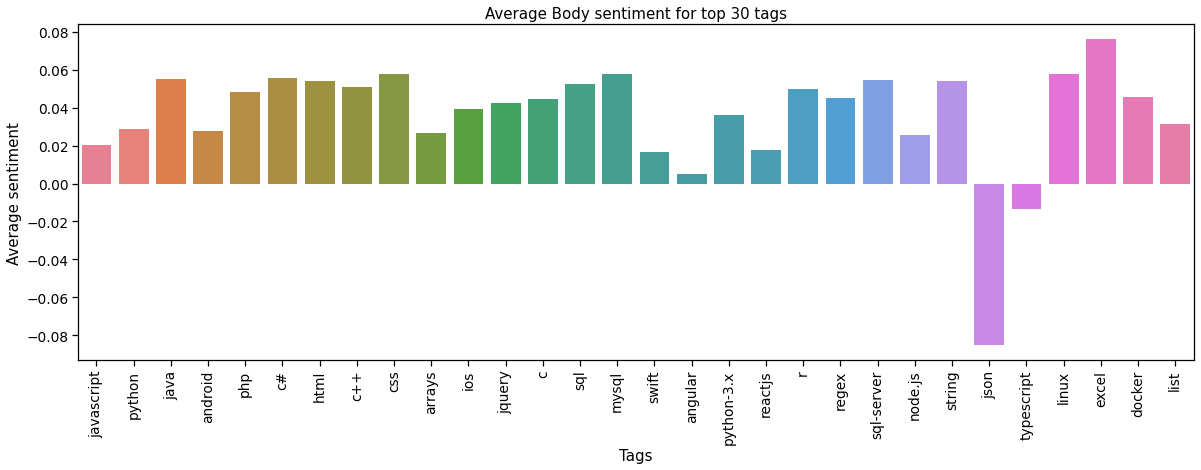

In [139]:
plot_average_body_sentiment_for_tags(train_with_features)

–í –æ—Å–Ω–æ–≤–Ω–æ–º –∞–ª–≥–æ—Ä–∏—Ç–º –æ—Ü–µ–Ω–∏–ª –≤–æ–ø—Ä–æ—Å—ã –ø–æ 30 –ø–æ–ø—É–ª—è—Ä–Ω—ã–º —Ç–µ–≥–∞–º –∫–∞–∫ –Ω–µ–π—Ç—Ä–∞–ª—å–Ω—ã–µ. –¢–µ–º –Ω–µ –º–µ–Ω–µ–µ –¥–≤–∞ —Ç–µ–≥–∞ (json –∏ typescript) –∏–º–µ—é—Ç –æ—Ü–µ–Ω–∫—É –Ω–∏–∂–µ –Ω—É–ª—è, —Ç–æ –µ—Å—Ç—å –∏–º–µ—é—Ç –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—É—é –Ω–µ–≥–∞—Ç–∏–≤–Ω—É—é –æ–∫—Ä–∞—Å–∫—É.

In [20]:
def columns_preprocess(data):
    data['text'] = data.Tags + " " + data.Title + " " + data.Body
    data.drop(columns=['Id', 'Body', 'Tags', 'Title', 'Tags_list'], inplace=True)
    data['text'] = data['text'].str.lower()
    return data

In [21]:
def text_preprocess(sentence):
    sentence = re.sub(r'[^(a-zA-Z)\s]',' ', sentence)
    sentence = re.sub(' +', ' ', sentence)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)

    filtered_sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words])
    return filtered_sentence

In [22]:
preprocessed_train = columns_preprocess(train)

In [25]:
preprocessed_train['text'] = preprocessed_train['text'].apply(text_preprocess)

In [144]:
preprocessed_train.head()

target                                               text
0       2  java algorithm graph algorithm implementing mi...
1       2  html r dataframe r studio date getting convert...
2       0  python panda dataframe panda groupby panda dat...
3       0  angular typescript rxjs casting result observa...
4       1  c window batch file environment variable set b...

In [50]:
def word_clouds(size, df, class_target):
    plt.figure(figsize=size)
    word_cloud = WordCloud(max_words=800, width=1500, height=1000).generate(" ".join(df[df['target'] == class_target].text))
    plt.imshow(word_cloud , interpolation = 'bilinear')

WordCloud –¥–ª—è –≤–æ–ø—Ä–æ—Å–æ–≤ HQ (target = 0): High-quality posts with 30+ score and without a single edit.

–°—É–¥—è –ø–æ —Ç–æ–º—É, —á—Ç–æ –≤ —ç—Ç–∏—Ö –≤–æ–ø—Ä–æ—Å–∞—Ö —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–æ `code`, –∞ —Ç–∞–∫–∂–µ —Å–ª–æ–≤–∞ `use`, `example`, –≤—ã—Å–æ–∫—É—é –æ—Ü–µ–Ω–∫—É –ø–æ–ª—É—á–∞–ª–∏ –≤–æ–ø—Ä–æ—Å—ã, –∫–æ—Ç–æ—Ä—ã–µ —Å–æ–¥–µ—Ä–∂–∞–ª–∏ –≤ —Å–µ–±–µ –ø—Ä–∏–º–µ—Ä—ã –∫–æ–¥–∞.

In [51]:
word_clouds((20, 20), preprocessed_train, 0)

WordCloud –¥–ª—è –≤–æ–ø—Ä–æ—Å–æ–≤ LQ_CLOSE (target =1): Low-quality posts that were closed by the community without a single edit.

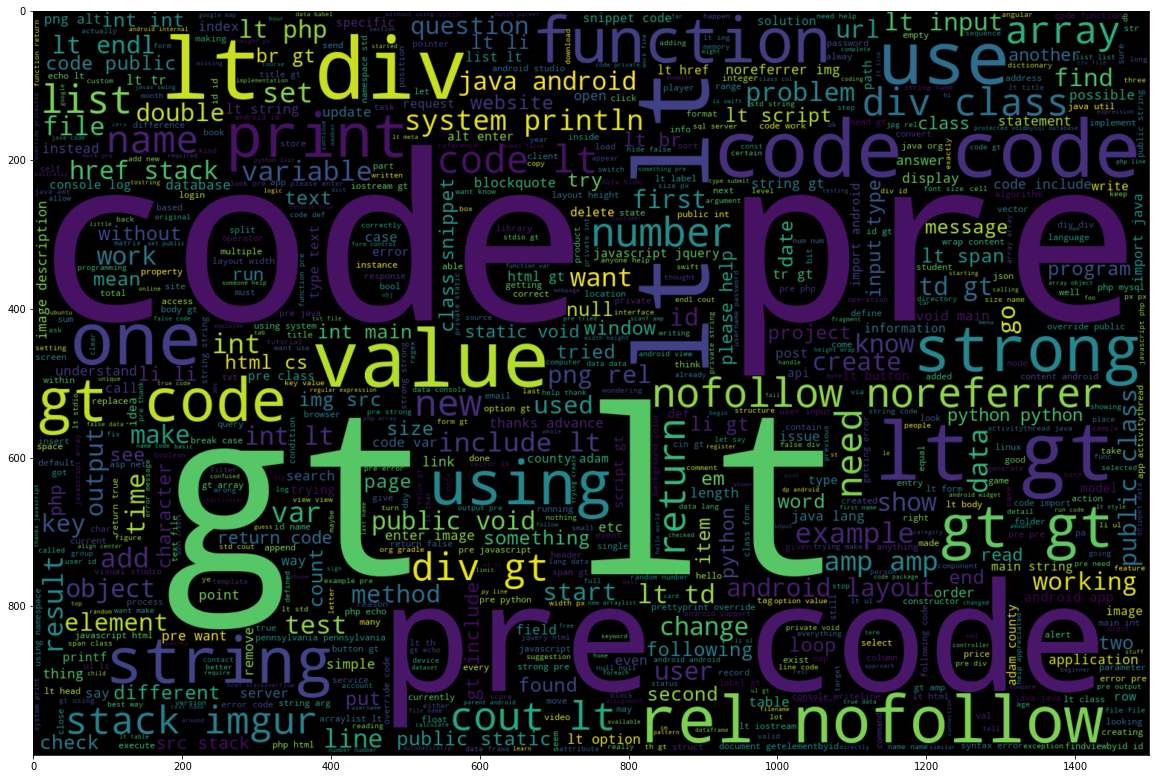

In [52]:
word_clouds((20, 20), preprocessed_train, 1)

WordCloud –¥–ª—è –≤–æ–ø—Ä–æ—Å–æ–≤ LQ_EDIT (target =2): Low-quality posts with a negative score and with multiple community edits.

In [53]:
word_clouds((20, 20), preprocessed_train, 2)

In [55]:
visualize_train = copy.deepcopy(preprocessed_train)

–í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º —á–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞ –≤ –≤–æ–ø—Ä–æ—Å–∞—Ö —Å –≤—ã—Å–æ–∫–æ–π –æ—Ü–µ–Ω–∫–æ–π. –ß–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–ª—Å—è html —Ç–µ–≥ `p`. –°–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, —ç—Ç–æ –æ–±—ä—è—Å–Ω—è–µ—Ç—Å—è —Ç–µ–º, —á—Ç–æ –∫–æ–≥–¥–∞ —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–∫–ª–∞–¥—ã–≤–∞–ª –∫ –≤–æ–ø—Ä–æ—Å—É —Å–≤–æ—é html —Ä–∞–∑–º–µ—Ç–∫—É, –≤ –Ω–µ–π —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–ª—Å—è —ç—Ç–æ—Ç —Ç–µ–≥, —Ç–∞–∫ –∫–∞–∫ –æ–Ω —è–≤–ª—è–µ—Ç—Å—è –¥–æ–≤–æ–ª—å–Ω–æ —á–∞—Å—Ç–æ –∏—Å–ø–æ–ª—å–∑—É–µ–º. –í—Ç–æ—Ä—ã–º –ø–æ –ø–æ–ø—É–ª—è—Ä–Ω–æ—Å—Ç–∏ —Å–ª–æ–≤–æ–º —è–≤–ª—è–µ—Ç—Å—è —Å–ª–æ–≤–æ `code`. –≠—Ç–æ –º–æ–∂–µ—Ç —Å–ª—É–∂–∏—Ç—å –µ—â–µ –æ–¥–Ω–∏–º –¥–æ–∫–∞–∑–∞—Ç–µ–ª—å—Å—Ç–≤–æ–º —Ç–µ–æ—Ä–∏–∏, —á—Ç–æ –≤–æ–ø—Ä–æ—Å—ã —Å –≤—ã—Å–æ–∫–æ–π –æ—Ü–µ–Ω–∫–æ–π —Å–æ–ø—Ä–æ–≤–æ–∂–¥–∞–ª–∏—Å—å –ø—Ä–∏–º–µ—Ä–∞–º–∏ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –∫–æ–¥–∞.

In [57]:
visualize_train['temp_list'] = visualize_train['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 0] for item in sublist])
top_hq = pd.DataFrame(top.most_common(15))
top_hq.columns = ['Common_words','count']

fig = px.bar(top_hq, x='count',y='Common_words',title='Common words in High Quality posts',orientation='h',width=700,height=500,color='Common_words')
fig.show()

–í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º —á–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞ –≤ –∑–∞–∫—Ä—ã—Ç—ã—Ö –≤–æ–ø—Ä–æ—Å–∞—Ö. –í –Ω–∏—Ö —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–ª–∏—Å—å –∫—Ä—É–≥–ª—ã–µ —Å–∫–æ–±–∫–∏. –í–æ–∑–º–æ–∂–Ω–æ, —ç—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –ª—é–¥–∏ –ø—Ä–∏–∫–ª–∞–¥—ã–≤–∞–ª–∏ –∫–æ–¥ —Å –∫–∞–∫–∏–º–∏-—Ç–æ –≥—Ä–æ–º–æ–∑–¥–∫–∏–º–∏ –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è–º–∏ (–ø–æ —Ç–∏–ø—É if (()&&()||()))

In [59]:
top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 1] for item in sublist])
top_lq = pd.DataFrame(top.most_common(15))
top_lq.columns = ['Common_words','count']

fig = px.bar(top_lq, x='count',y='Common_words',title='Common words in Low Quality posts(Closed)',orientation='h',width=700,height=500,color='Common_words')
fig.show()

–ó–∞–º–µ—Ç–∏–º, —á—Ç–æ –≤ –æ—Ç–∫—Ä—ã—Ç—ã—Ö –≤–æ–ø—Ä–æ—Å–∞—Ö —Å –Ω–∏–∑–∫–æ–π –æ—Ü–µ–Ω–∫–æ–π —É–∂–µ –Ω–µ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è html —Ç–µ–≥–æ–≤. –°–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, —ç—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –≤ –≤–µ–± —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–µ –±–æ–ª—å—à–æ–µ —Å–æ–æ–±—â–µ—Å—Ç–≤–æ, –∏ –≤–æ–ø—Ä–æ—Å—ã –±—ã—Å—Ç—Ä–µ–µ —Ä–∞–∑—Ä–µ—à–∞—é—Ç—Å—è –∏–ª–∏ –∑–∞–∫—Ä—ã–≤–∞—é—Ç—Å—è, –∞ –Ω–µ –æ—Å—Ç–∞—é—Ç—Å—è –æ—Ç–∫—Ä—ã—Ç—ã–º–∏.

In [60]:
top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 2] for item in sublist])
top_lq = pd.DataFrame(top.most_common(15))
top_lq.columns = ['Common_words','count']

fig = px.bar(top_lq, x='count',y='Common_words',title='Common words in Low Quality posts(Open)',orientation='h',width=700,height=500,color='Common_words')
fig.show()

## Embeddings

- one hot encoding
- word2vec –æ–±—É—á–µ–Ω–Ω—É—é / —Å–∞–º–∏–º –æ–±—É—á–∏—Ç—å
- fasttext –æ–±—É—á–µ–Ω–Ω—É—é / —Å–∞–º–∏–º –æ–±—É—á–∏—Ç—å
- tf-idf

In [ ]:
def get_model_vectors(corpus, model):    
    
  def get_vector(sentence):   
    word_tokens = word_tokenize(sentence)
    vector = 0
    for word in word_tokens:
      try: 
        vector += model.wv[word]
      except:
        continue
    return vector
    
  out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
  return out_corpus

In [26]:
sentences = [row.split() for row in preprocessed_train['text']]     # —Å–ø–∏—Å–æ–∫ —Å–ª–æ–≤ –≤ –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–µ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
repeat_vocab = [item for sublist in sentences for item in sublist]  # –≤—Å–µ —Å–ª–æ–≤–∞, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ
vocab = set(repeat_vocab)                                           # —É–±–µ—Ä–µ–º –ø–æ–≤—Ç–æ—Ä—è—é—â–∏–µ—Å—è —Å–ª–æ–≤–∞ –∏ –ø–æ–ª—É—á–∏–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞

#### Count Vectorizer

–û–±—É—á–∏–º CountVectorizer –∏ –¥–∞–¥–∏–º –µ–º—É –Ω–∞ –≤—Ö–æ–¥ –ø–æ—Å—Ç—Ä–æ–µ–Ω–Ω—ã–π —Å–ª–æ–≤–∞—Ä—å. –¢–æ –∂–µ —Å–∞–º–æ–µ –ø—Ä–æ–¥–µ–ª–∞–µ–º –¥–ª—è TFIDF

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.7, min_df=2, max_features=20, vocabulary=vocab)
count_vectorizer_data = count_vectorizer.fit_transform(train['text'])

#### Word2Vec

–°–æ–∑–¥–∞–¥–∏–º Word2Vec –º–æ–¥–µ–ª—å –∏ –æ–±—É—á–∏–º –µ–µ –Ω–∞ —Å–ª–æ–≤–∞—Ö –∏–∑ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞, –∞ –∑–∞—Ç–µ–º –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ–∫—Å—Ç –≤ –≤–µ–∫—Ç–æ—Ä–∞. –¢–æ –∂–µ —Å–∞–º–æ–µ –ø—Ä–æ–¥–µ–ª–∞–µ–º –¥–ª—è –æ—Å—Ç–∞–ª—å–Ω—ã—Ö gensim –º–æ–¥–µ–ª–µ–π –≤ —Ç–æ–º —á–∏—Å–ª–µ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã—Ö.

In [ ]:
word2vec_model = gensim.models.Word2Vec(size=100, min_count=5, window=5)

In [ ]:
word2vec_model.build_vocab(sentences=sentences)

In [ ]:
word2vec_model.train(sentences=sentences, total_examples=len(sentences), epochs=10)

(43409989, 56475490)

In [ ]:
word2vec_vectors = get_model_vectors(preprocessed_train['text'], word2vec_model)

#### Word2Vec pretrained

In [ ]:
word2vec_model_pretrained = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
pretrained_word2vec_vectors = get_model_vectors(preprocessed_train['text'], word2vec_model_pretrained)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


#### FastText

In [27]:
fasttext_model = gensim.models.FastText(size=100, window=5, min_count=5)

In [28]:
fasttext_model.build_vocab(sentences=sentences)

In [29]:
fasttext_model.train(sentences=sentences, total_examples=len(sentences), epochs=10)

In [150]:
fasttext_vectors = get_model_vectors(preprocessed_train['text'], fasttext_model)

##### FastText vizualization

In [39]:
words = sorted(fasttext_model.wv.vocab, 
               key=lambda word: fasttext_model.wv.vocab[word].count,
               reverse=True)[:1000]

In [43]:
word_vectors = np.array([fasttext_model.wv.get_vector(vector) for vector in words])

In [45]:
pca = PCA(n_components=2)
pca.fit(word_vectors)
word_vectors_pca = pca.transform(word_vectors)
word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(axis=0)) / word_vectors_pca.std(axis=0)

In [47]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=500, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [48]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1159', ...)

–î–∞–ª—å—à–µ –≤—Å–µ—Ö –æ—Ç –æ—Å–Ω–æ–≤–Ω–æ–π –º–∞—Å—Å—ã —Å–ª–æ–≤ —Ä–∞—Å–ø–æ–ª–∞–≥–∞—é—Ç—Å—è —Ç–∞–∫–∏–µ —Å–ø–µ—Ü–∏—Ñ–∏—á–Ω—ã–µ —Å–ª–æ–≤–∞ –∫–∞–∫ —Ä–∞—Å—à–∏—Ä–µ–Ω–∏—è —Ñ–∞–π–ª–æ–≤, html —Ç–µ–≥–∏, —Å–æ–∫—Ä–∞—â–µ–Ω–∏—è, –¥–æ–º–µ–Ω–Ω–∞—è –∑–æ–Ω–∞. –û–Ω–∏ —É–ø–æ—Ç—Ä–µ–±–ª—è—é—Ç—Å—è –≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω–æ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ –∏ –∏–º–µ—é—Ç —Å—Ç—Ä–æ–≥–æ–µ –æ–¥–Ω–æ–∑–Ω–∞—á–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ, –ø–æ—ç—Ç–æ–º—É –º–∞–ª–æ –∫–∞–∫–∏–µ —Å–ª–æ–≤–∞ —Å –Ω–∏–º–∏ –ø–µ—Ä–µ—Å–µ–∫–∞—é—Ç—Å—è. –í–Ω—É—Ç—Ä–∏ –æ—Å–Ω–æ–≤–Ω–æ–π –º–∞—Å—Å—ã —Å–ª–æ–≤–∞ –Ω–µ—è–≤–Ω–æ —Ä–∞–¥–µ–ª—è—é—Ç—Å—è –Ω–∞ –¥–≤–µ –≥—Ä—É–ø–ø—ã - —Ç–µ—Ä–º–∏–Ω—ã –∏–∑ –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏—è (`void`, `mysql`, `lambda`, `await`) –∏ '–æ–±—ã—á–Ω—ã–µ' —Å–ª–æ–≤–∞ (`know`, `everything`, `solve`, `simple`). –û–Ω–∏ –±–ª–∏–∑–∫–∏ –¥—Ä—É–≥ –∫ –¥—Ä—É–≥—É, —Ç–∞–∫ —É–ø–æ—Ç—Ä—è–±–ª—è—é—Ç—Å—è –≤ –æ–¥–Ω–æ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ –≤–æ–ø—Ä–æ—Å–æ–≤ –ø–æ –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏—é. –ï—Å–ª–∏ –±—ã –º—ã —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞–ª–∏ –±–æ–ª–µ–µ —Ä–∞–∑–Ω–æ–ø–ª–∞–Ω–æ–≤—ã–µ —Ç–µ–∫—Å—Ç—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, –≤–æ–ø—Ä–æ—Å—ã –ø–æ –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏—é, —Å—Ç–∞—Ç—å–∏ –ø—Ä–æ –∫–æ—Ç–∏–∫–æ–≤, –∫—É–ª–∏–Ω–∞—Ä–Ω—ã–µ —Ä–µ—Ü–µ–ø—Ç—ã), –º–æ–∂–Ω–æ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç—å, —á—Ç–æ '–æ–±—ã—á–Ω—ã–µ' —Å–ª–æ–≤–∞ –Ω–∞—Ö–æ–¥–∏–ª–∏—Å—å –±—ã –¥–∞–ª–µ–∫–æ –æ—Ç —Ç–µ—Ä–º–∏–Ω–æ–≤, —Å–≤—è–∑–∞–Ω–Ω—ã—Ö —Å –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ–º, —Ç–∞–∫ –∫–∞–∫ –Ω–∞–º–Ω–æ–≥–æ —Ä–µ–∂–µ —É–ø–æ—Ç—Ä—è–±–ª—è–ª–∏—Å—å –≤ –æ–¥–Ω–æ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ.

#### FastText pretrained

In [ ]:
fasttext_model_pretrained = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/data/wiki-news-300d-1M.vec')

In [ ]:
pretrained_fasttext_vectors = get_model_vectors(preprocessed_train['text'], fasttext_model_pretrained)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


#### TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.5, min_df=3, max_features=20, vocabulary=vocab)
tfidf_data = tfidf_vectorizer.fit_transform(train['text'])

## Classical algorithms

–û—Ç–±–µ—Ä–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö ML –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –∏ –ø–æ–ø—Ä–æ–±—É–µ–º –æ–±—É—á–∏—Ç—å –∏—Ö –Ω–∞ —Ä–∞–∑–Ω—ã—Ö embeddings, —á—Ç–æ–±—ã –∑–∞—Ç–µ–º –≤—ã–±—Ä–∞—Ç—å –Ω–∞–∏–±–æ–ª–µ–µ –ø–æ–¥—Ö–æ–¥—è—â–∏–π –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏. –û—Ü–µ–Ω–∏–≤–∞—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –±—É–¥–µ–º –ø–æ –º–µ—Ç—Ä–∏–∫–µ accuracy. –ß–µ–º –≤—ã—à–µ accuracy, —Ç–µ–º –ª—É—á—à–µ.

In [151]:
y = preprocessed_train['target']

In [152]:
embeddings = {'count_vectorizer' :    (train_test_split(count_vectorizer_data, y, test_size=0.2, random_state=2020)),
              'tf_idf' :              (train_test_split(tfidf_data, y, test_size=0.2, random_state=2020)),
              'fasttext' :            (train_test_split(fasttext_vectors, y, test_size=0.2, random_state=2020)),
              'pretrained_fasttext' : (train_test_split(pretrained_fasttext_vectors, y, test_size=0.2, random_state=2020)),
              'word2vec' :            (train_test_split(word2vec_vectors, y, test_size=0.2, random_state=2020)),
              'pretrained_word2vec' : (train_test_split(pretrained_word2vec_vectors, y, test_size=0.2, random_state=2020)),
              } 
              # X_train, X_test, y_train, y_test

In [ ]:
classifiers = {'logreg': LogisticRegression(max_iter=1000),
               'svm' : SVC(),          
               'random_forest': RandomForestClassifier(),
               'decision_tree': DecisionTreeClassifier(),
               'ada_boost': AdaBoostClassifier(),
               'cat_boost': CatBoostClassifier(verbose=False)}

In [ ]:
best_classifiers = {'svm' : [],
                    'logreg': [],
                    'random_forest': [],
                    'decision_tree': [],
                    'ada_boost': [],
                    'cat_boost': []}

In [ ]:
for clf_name, clf in classifiers.items():
  for emb_name, embedding in embeddings.items():
    print(f'Fit algorithm {clf_name} with embedding {emb_name}')
    clf.fit(embedding[0], embedding[2])
    test_accuracy = accuracy_score(embedding[3], clf.predict(embedding[1]))
    best_classifiers[clf_name].append({ emb_name: test_accuracy})

Fit algorithm logreg with embedding count_vectorizer
Fit algorithm logreg with embedding tf_idf
Fit algorithm logreg with embedding fasttext


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit algorithm logreg with embedding pretrained_fasttext


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit algorithm logreg with embedding word2vec
Fit algorithm logreg with embedding pretrained_word2vec
Fit algorithm svm with embedding count_vectorizer
Fit algorithm svm with embedding tf_idf
Fit algorithm svm with embedding fasttext
Fit algorithm svm with embedding pretrained_fasttext
Fit algorithm svm with embedding word2vec
Fit algorithm svm with embedding pretrained_word2vec
Fit algorithm random_forest with embedding count_vectorizer
Fit algorithm random_forest with embedding tf_idf
Fit algorithm random_forest with embedding fasttext
Fit algorithm random_forest with embedding pretrained_fasttext
Fit algorithm random_forest with embedding word2vec
Fit algorithm random_forest with embedding pretrained_word2vec
Fit algorithm decision_tree with embedding count_vectorizer
Fit algorithm decision_tree with embedding tf_idf
Fit algorithm decision_tree with embedding fasttext
Fit algorithm decision_tree with embedding pretrained_fasttext
Fit algorithm decision_tree with embedding word2vec
Fi

In [ ]:
best_classifiers

{'ada_boost': [{'count_vectorizer': 0.7463541666666667},
  {'tf_idf': 0.7459375},
  {'fasttext': 0.7715625},
  {'pretrained_fasttext': 0.7182291666666667},
  {'word2vec': 0.7301041666666667},
  {'pretrained_word2vec': 0.7094791666666667}],
 'cat_boost': [{'count_vectorizer': 0.8183333333333334},
  {'tf_idf': 0.8230208333333333},
  {'fasttext': 0.86375},
  {'pretrained_fasttext': 0.8454166666666667},
  {'word2vec': 0.8354166666666667},
  {'pretrained_word2vec': 0.8377083333333334}],
 'decision_tree': [{'count_vectorizer': 0.7502083333333334},
  {'tf_idf': 0.7478125},
  {'fasttext': 0.7303125},
  {'pretrained_fasttext': 0.63},
  {'word2vec': 0.653125},
  {'pretrained_word2vec': 0.6198958333333333}],
 'logreg': [{'count_vectorizer': 0.8038541666666666},
  {'tf_idf': 0.8151041666666666},
  {'fasttext': 0.8455208333333334},
  {'pretrained_fasttext': 0.8441666666666666},
  {'word2vec': 0.7957291666666667},
  {'pretrained_word2vec': 0.8277083333333334}],
 'random_forest': [{'count_vectorizer'

–í–æ–∑—å–º–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –¥–∞–ª–∏ –Ω–∞–∏–ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –ø–æ–ø—Ä–æ–±—É–µ–º –ø–æ–¥–æ–±—Ä–∞—Ç—å –¥–ª—è –Ω–∏—Ö –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã. –ò –ø–µ—Ä–µ–¥ –Ω–∞–º–∏ —Ñ–∏–Ω–∞–ª–∏—Å—Ç—ã:


*   logreg with fasttext (0.849)
*   logreg with Pretrained FastText (0.844)
*   RandomForestClassifier with fasttext (0.834)
*   SVM with fasttext (0.859)
*   SVM with Pretrained Word2Vec (0.837)
*   Catboost with fasttext (0.86375)








#### –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ª—É—á—à–∏—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤

Note: –î–ª—è SVM –Ω–µ –æ–ø–∏—Å–∞–Ω –ø–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, —Ç–∞–∫ –∫–∞–∫ –º–µ—Ç–æ–¥–æ–º –ø—Ä–æ–± –∏ –æ—à–∏–±–æ–∫ –±—ã–ª–æ –≤—ã—è—Å–Ω–µ–Ω–æ, —á—Ç–æ –ª—É—á—à–µ –≤—Å–µ–≥–æ –æ–Ω —Ä–∞–±–æ—Ç–∞–µ—Ç —Å–æ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏, –∞ GridSearchCV –∑–∞–Ω–∏–º–∞–µ—Ç –¥–ª—è –Ω–µ–≥–æ –±–æ–ª—å—à–µ –¥–≤—É—Ö —á–∞—Å–æ–≤

##### Random Forest

In [ ]:
clf_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                       param_grid={'max_depth': [None, 1, 2, 3, 4, 5], 
                                   'criterion': ['gini', 'entropy'],
                                   'min_samples_split': [2, 4, 6],
                                   'min_samples_leaf': [1, 2, 3]
                                   }, n_jobs=-1)

In [ ]:
clf_rf.fit(embeddings['fasttext'][0], embeddings['fasttext'][2])

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

In [ ]:
clf_rf.best_params_, clf_rf.best_score_

({'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 4},
 0.8394010416666667)

In [ ]:
random_forest_best_criterion = clf_rf.best_params_['criterion']
random_forest_best_max_depth = clf_rf.best_params_['max_depth']
random_forest_best_min_samples_leaf = clf_rf.best_params_['min_samples_leaf']
random_forest_best_min_samples_split = clf_rf.best_params_['min_samples_split']

##### Logistic regression

In [ ]:
clf_logr = GridSearchCV(LogisticRegression(max_iter=1000), 
                        param_grid={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                                    'random_state' : [42]}, n_jobs=-1)

In [ ]:
clf_logr.fit(embeddings['fasttext'][0], embeddings['fasttext'][2])

In [ ]:
clf_logr.best_params_, clf_logr.best_score_

({'penalty': 'l2', 'random_state': 42}, 0.8575260416666668)

In [ ]:
logr_fasttext_best_penalty = clf_logr.best_params_['penalty']

In [ ]:
clf_logr.fit(embeddings['pretrained_fasttext'][0], embeddings['pretrained_fasttext'][2])

In [ ]:
clf_logr.best_params_, clf_logr.best_score_

({'penalty': 'l2', 'random_state': 42}, 0.8472135416666667)

In [ ]:
logr_prefasttext_best_penalty = clf_logr.best_params_['penalty']

#### –ó–∞–ø—É—Å–∫ –ª—É—á—à–∏—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏

##### SVM

In [ ]:
svm = SVC()

In [ ]:
svm_fasttext_pred = svm.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], svm_fasttext_pred)

0.8586458333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != svm_fasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1357


In [ ]:
svm_word2vec_pred = svm.fit(embeddings['pretrained_word2vec'][0], embeddings['pretrained_word2vec'][2]).predict(embeddings['pretrained_word2vec'][1])

In [ ]:
accuracy_score(embeddings['pretrained_word2vec'][3], svm_word2vec_pred)

0.8370833333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['pretrained_word2vec'][1].shape[0], (embeddings['pretrained_word2vec'][3] != svm_word2vec_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1564


##### Random Forest

In [ ]:
random_forest = RandomForestClassifier(max_depth=random_forest_best_max_depth, criterion=random_forest_best_criterion, 
                                       min_samples_leaf=random_forest_best_min_samples_leaf, min_samples_split=random_forest_best_min_samples_split)
random_forest_pred = random_forest.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], random_forest_pred)

0.8352083333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != random_forest_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1582


##### Logreg

In [ ]:
logreg_fasttext = LogisticRegression(max_iter=1000, penalty=logr_fasttext_best_penalty, random_state=42)
logreg_fasttext_pred = logreg_fasttext.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], logreg_fasttext_pred)

0.8479166666666667

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != logreg_fasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1460


In [ ]:
logreg_fasttext = LogisticRegression(max_iter=1000, penalty=logr_prefasttext_best_penalty, random_state=42)
logreg_prefasttext_pred = logreg_prefasttext.fit(embeddings['pretrained_fasttext'][0], embeddings['pretrained_fasttext'][2]).predict(embeddings['pretrained_fasttext'][1])

In [ ]:
accuracy_score(embeddings['pretrained_fasttext'][3], logreg_prefasttext_pred)

0.8441666666666666

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['pretrained_fasttext'][1].shape[0], (embeddings['pretrained_fasttext'][3] != logreg_prefasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1496


##### Catboost

In [155]:
cat_boost = CatBoostClassifier(iterations=2000, verbose=False)

In [156]:
cat_boost_pred = cat_boost.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [157]:
accuracy_score(embeddings['fasttext'][3], cat_boost_pred)

0.8680208333333334

–ö–∞–∫ –≤–∏–¥–∏–º, –ø–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –ø–æ–∑–≤–æ–ª–∏–ª —É–ª—É—á—à–∏—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –¥–ª—è –∞–ª–≥–æ—Ä–∏—Ç–º–∞ Random Forest. –í—Å–µ –æ—Å—Ç–∞–ª—å–Ω—ã–µ –∞–ª–≥–æ—Ä–∏—Ç–º—ã –ª—É—á—à–µ –≤—Å–µ–≥–æ —Ä–∞–±–æ—Ç–∞—é—Ç —Å–æ —Å–≤–æ–∏–º–∏ –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏. –°–∞–º—ã–π –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ–∫–∞–∑–∞–ª –∞–ª–≥–æ—Ä–∏—Ç–º Catboost - –ø–æ—á—Ç–∏ 0.87 üí™. –ü—Ä–∏ –ø–æ–º–æ—â–∏ –Ω–µ–≥–æ –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º –∏ –±—É–¥–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—Ç—å –∫–ª–∞—Å—Å—ã –¥–ª—è –Ω–∞—à–∏—Ö —Ç–µ—Å—Ç–æ–≤—ã—Ö (–Ω–µ—Ä–∞–∑–º–µ—á–µ–Ω–Ω—ã—Ö) –¥–∞–Ω–Ω—ã—Ö. 

#### LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=15,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=2020)

In [ ]:
count_data_lda = lda.fit_transform(count_vectorizer_data)

In [ ]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_vectorizer_data, count_vectorizer)

–õ–∞—Ç–µ–Ω—Ç–Ω–æ–µ —Ä–∞–∑–º–µ—â–µ–Ω–∏–µ –î–∏—Ä–∏—Ö–ª–µ –ø–æ–∑–≤–æ–ª—è–µ—Ç —Ä–∞–∑–¥–µ–ª—è—Ç—å –¥–∞–Ω–Ω—ã–µ –≤ –Ω–µ—è–≤–Ω—ã–µ –≥—Ä—É–ø–ø—ã. –î–∞–Ω–Ω—ã–µ –±—ã–ª–∏ —Ä–∞–∑–¥–µ–ª–µ–Ω—ã –Ω–∞ –ø—è—Ç—å –≥—Ä—É–ø–ø. –°—Ä–µ–¥–∏ –Ω–∏—Ö —Ç—Ä–∏ –∏–º–µ—é—Ç –±–ª–∏–∑–∫–æ–µ —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω–∏–µ –∏ –ø–µ—Ä–µ—Å–µ–∫–∞—é—Ç—Å—è, –∞ –¥–≤–µ –∑–∞–º–µ—Ç–Ω–æ —É–¥–∞–ª–µ–Ω—ã –æ—Ç –Ω–∏—Ö. –í –æ–¥–Ω—É –≥—Ä—É–ø–ø—É –ø–æ–ø–∞–ª–∏ –≤–æ–ø—Ä–æ—Å—ã –æ –±–∞–∑–∞—Ö –¥–∞–Ω–Ω—ã—Ö (—Å—É–¥—è –ø–æ —Å–ª–æ–≤–∞–º `id`, `table`, `data`, `sql`, `database`). –í –¥—Ä—É–≥—É—é –≤–æ–ø—Ä–æ—Å—ã –ø–æ –° (—Å—É–¥—è –ø–æ —Å–ª–æ–≤–∞–º `int`, `char`, `printf`, `void`), –≤–æ–∑–º–æ–∂–Ω–æ –ø–æ –Ω–∏–∑–∫–æ—É—Ä–æ–≤–Ω–µ–≤—ã–º —è–∑—ã–∫–∞–º –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏—è. –í –æ—Å—Ç–∞–ª—å–Ω—ã–µ –≥—Ä—É–ø–ø—ã –±—ã–ª–∏ –æ—Ç–Ω–µ—Å–µ–Ω—ã –æ–±—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã –ø–æ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã–º —è–∑—ã–∫–∞–º, —Ç–∞–∫ –∫–∞–∫ —ç—Ç–∏—Ö –≥—Ä—É–ø–ø–∞—Ö –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è —Å–ª–æ–≤–∞ `android`, `java`, `array`. –ü—Ä–∏ —ç—Ç–æ–º –æ–¥–Ω–∞ –∏–∑ –≥—Ä—É–ø–ø –ø–æ—Ö–æ–∂–∞ –Ω–∞ –≤–æ–ø—Ä–æ—Å—ã –ø–æ –≤–µ–±-—Ä–∞–∑—Ä–∞–±–æ—Ç–∫–µ, —Ç–∞–∫ –∫–∞–∫ –≤ –Ω–µ–π –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è —Å–ª–æ–≤–∞ –∏–∑ html (`gt` - greater-than sign, `lt` - less-than sign, `div`, `href`)

In [ ]:
pyLDAvis.display(LDAvis_prepared)

#### Classification with features


–ü–æ–ø—Ä–æ–±—É–µ–º –µ—â–µ —É—á–µ—Å—Ç—å –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å–æ–∑–¥–∞–Ω–Ω—ã–µ –Ω–∞–º–∏ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏. –í –æ—Å–Ω–æ–≤–Ω–æ–º –∞–ª–≥–æ—Ä–∏—Ç–º—ã –ª—É—á—à–µ –≤—Å–µ–≥–æ —Ä–∞–±–æ—Ç–∞–ª–∏ —Å —ç–º–±–µ–¥–∏–Ω–≥–æ–º fasttext, –ø–æ—ç—Ç–æ–º—É —Ä–∞–∑–¥–µ–ª–∏–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –Ω–æ–≤—ã–º–∏ —Ñ–∏—á–∞–º–∏ –Ω–∞ test –∏ train –ø–æ —ç—Ç–æ–º—É —ç–º–±–µ–¥–∏–Ω–≥—É, —á—Ç–æ–±—ã –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å test –ø–æ —Ç–µ–º –∂–µ –¥–∞–Ω–Ω—ã–º. –í–æ–∑—å–º–µ–º —Ç–µ –∂–µ –∞–ª–≥–æ—Ä–∏—Ç–º—ã, —á—Ç–æ –∏ –¥–ª—è —Ç–µ–∫—Å—Ç–æ–≤–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∏ –≤—ã–±–µ—Ä–µ–º –∏–∑ –Ω–∏—Ö —Ç–æ, –∫–æ—Ç–æ—Ä—ã–π –¥–∞–µ—Ç —Å–∞–º—ã–π –≤—ã—Å–æ–∫–∏–π accuracy.

In [ ]:
emb_y_train = pd.DataFrame(embeddings['fasttext'][2])
emb_y_test = pd.DataFrame(embeddings['fasttext'][3])

In [ ]:
train_with_features.drop(columns=['Id', 'Body', 'Tags', 'Title', 'Tags_list'], inplace=True)

In [ ]:
train_features = train_with_features[train_with_features.index.isin(emb_y_train.index)]
test_features = train_with_features[train_with_features.index.isin(emb_y_test.index)]

In [ ]:
y_train_features = train_features['target']
y_test_features = test_features['target']
X_train_features = copy.deepcopy(train_features)
X_test_features = copy.deepcopy(test_features)

X_train_features.drop(columns=['target'], inplace=True)
X_test_features.drop(columns=['target'], inplace=True)

In [ ]:
classifiers_features = {'logreg': LogisticRegression(max_iter=1000),
               'svm' : SVC(),          
               'random_forest': RandomForestClassifier(),
               'decision_tree': DecisionTreeClassifier(),
               'ada_boost': AdaBoostClassifier(),
               'cat_boost': CatBoostClassifier(verbose=False)}

In [ ]:
best_classifiers_features = {'svm' : [],
                             'logreg': [],
                             'random_forest': [],
                             'decision_tree': [],
                             'ada_boost': [],
                             'cat_boost': []}

In [ ]:
for clf_name, clf in classifiers_features.items():
  print(f'Fit algorithm {clf_name}')
  clf.fit(X_train_features, y_train_features)
  test_accuracy = accuracy_score(y_test_features, clf.predict(X_test_features))
  best_classifiers_features[clf_name].append(test_accuracy)

In [ ]:
best_classifiers_features

{'ada_boost': [0.57375],
 'cat_boost': [0.6283333333333333],
 'decision_tree': [0.49614583333333334],
 'logreg': [0.5191666666666667],
 'random_forest': [0.605],
 'svm': [0.48270833333333335]}

–õ—É—á—à–µ –≤—Å–µ–≥–æ —Å–µ–±—è –ø–æ–∫–∞–∑–∞–ª–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã Random Forest –∏ Catboost, –∑–Ω–∞—á–∏—Ç –ø–æ–ø—Ä–æ–±—É–µ–º –¥–æ–±–∞–≤–∏—Ç—å –∫–∞–∂–¥—ã–π –∏–∑ –Ω–∏—Ö –≤ –∞–Ω—Å–∞–º–±–ª—å. –ü—Ä–µ–¥—Å–∫–∞–∂–µ–º –∫–ª–∞—Å—Å—ã –ø–æ —Ç–µ–∫—Å—Ç—É –ø—Ä–∏ –ø–æ–º–æ—â–∏ SVM, –∞ –∫–ª–∞—Å—Å—ã –ø–æ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º —Ñ–∏—á–∞–º –ø—Ä–∏ –ø–æ–º–æ—â–∏ Random Forest –∏ Catboost, –∏ –º–µ—Ç–æ–¥–æ–º –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è —Ä–µ—à–∏–º, –∫ –∫–∞–∫–æ–º—É –∫–ª–∞—Å—Å—É –æ—Ç–Ω–æ—Å–∏—Ç—Å—è –≤–æ–ø—Ä–æ—Å. –°–ª–æ–∂–∏–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—é—Ç –∫–∞–∂–¥—ã–π –∏–∑ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤, –∏ –¥–∞–¥–∏–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä—É –ø–æ —Ñ–∏—á–∞–º –º–µ–Ω—å—à–∏–π –≤–µ—Å, —Ç–∞–∫ –∫–∞–∫ –æ–Ω –æ—à–∏–±–∞–µ—Ç—Å—è —á–∞—â–µ.

In [ ]:
random_forest_features = RandomForestClassifier()

In [ ]:
rf_pred_proba = random_forest_features.fit(X_train_features, y_train_features).predict_proba(X_test_features)

In [ ]:
svm = SVC(probability=True)

In [ ]:
svm_pred_proba = svm.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict_proba(embeddings['fasttext'][1])

In [ ]:
def find_best_class(features_pred, text_pred):
  pred_classes = []
  for i in range(len(features_pred)):
    # –≤–æ–∑—å–º–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –∫–ª–∞—Å—Å–æ–≤, –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –ø–æ –Ω–æ–≤—ã–º —Ñ–∏—á–∞–º —Å –≤–µ—Å–æ–º 0.1, –∞ –ø–æ —Ç–µ–∫—Å—Ç—É —Å –≤–µ—Å–æ–º 0.9
    probabilities = [(0.1 * x + 0.9 * y) for x, y in zip(features_pred[i], text_pred[i])]
    pred_classes.append(probabilities.index(max(probabilities)))
  return pred_classes

In [ ]:
ens_pred_classes = find_best_class(rf_pred_proba, svm_pred_proba)

In [ ]:
accuracy_score(embeddings['fasttext'][3], ens_pred_classes)

0.8614583333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != ens_pred_classes).sum()))

Number of mislabeled points out of a total 9600 points : 1692


In [ ]:
cat_boost_features = CatBoostClassifier(verbose=False)

In [ ]:
cat_boost_features_pred_proba = cat_boost_features.fit(X_train_features, y_train_features).predict_proba(X_test_features)

In [ ]:
cat_svm_pred_classes = find_best_class(cat_boost_features_pred_proba, svm_pred_proba)

In [ ]:
accuracy_score(embeddings['fasttext'][3], cat_svm_pred_classes)

0.8617708333333334

–ù–∞–º –Ω–µ–º–Ω–æ–≥–æ —É–¥–∞–ª–æ—Å—å —É–ª—É—á—à–∏—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –¥–ª—è SVM –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞, –Ω–æ –æ–Ω –≤—Å–µ —Ä–∞–≤–Ω–æ —É—Å—Ç—É–ø–∞–µ—Ç CatBoost. –í—ã —Å–∫–∞–∂–µ—Ç–µ, —á—Ç–æ –º–æ–∂–Ω–æ –±—ã–ª–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –¥–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ CatBoost, —Ä–∞–∑ –æ–Ω–∏ –¥–∞—é—Ç —Å–∞–º—ã–µ —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã. –ò –º—ã –ø–æ–ø—Ä–æ–±–æ–≤–∞–ª–∏, –Ω–æ —Å—Ç–∞–ª–æ —Ç–æ–ª—å–∫–æ —Ö—É–∂–µ ‚òπÔ∏è

## Neural networks

–¢–µ–ø–µ—Ä—å –ø–æ–ø—Ä–æ–±—É–µ–º –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –≤–æ–ø—Ä–æ—Å—ã –ø—Ä–∏ –ø–æ–º–æ—â–∏ –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π. –ü–æ–ø—Ä–æ–±—É–µ–º –¥–≤–∞ –≤–∞—Ä–∏–∞–Ω—Ç–∞ - –ø–æ—Å—Ç—Ä–æ–∏–º –Ω–µ–π—Ä–æ—Å–µ—Å—Ç—å –æ—Ç–¥–µ–ª—å–Ω–æ –¥–ª—è –∫–æ–ª–æ–Ω–æ–∫ `Body`, `Tags`, `Title` –∏ –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞. 

In [97]:
train = pd.read_parquet('/content/drive/My Drive/data/train.parquet')
train = train.reset_index()

In [98]:
text_columns = ['Body', 'Tags', 'Title']
target_column = 'target'

In [99]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [100]:
train['Body'] = train['Body'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)
train['Title'] = train['Title'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)
train['Tags'] = train['Tags'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)

In [101]:
token_counts = Counter(token for col in text_columns
                             for item in train[col]
                             for token in item.split())

In [102]:
min_count = 10

tokens = [token for token, count in token_counts.items() if count >= min_count]

In [103]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 24753


In [104]:
token_to_id = dict(map(reversed, enumerate(tokens)))

In [105]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [106]:
data_train, data_val = train_test_split(train, test_size=0.2, random_state=2020)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  38400
Validation size =  9600


In [107]:
def make_batch(data, max_len=None, word_dropout=0):
  batch = {}
  batch["Title"] = as_matrix(data["Title"].values, max_len)
  batch["Body"] = as_matrix(data["Body"].values, max_len)
  batch["Tags"] = as_matrix(data["Tags"].values, max_len)
  batch[target_column] = data[target_column].values
    
  return batch

In [108]:
def build_model(n_tokens=len(tokens)):
    
    l_title = L.Input(shape=[None], name="Title")
    l_body = L.Input(shape=[None], name="Body")
    l_tags = L.Input(shape=[None], name="Tags")
    
    emb = L.Embedding(len(tokens), 128)

    l_title_emb = emb(l_title)
    l_title_emb = L.Dense(128)(l_title_emb)
    l_title_emb = L.GlobalMaxPool1D()(l_title_emb) 
    l_title_emb = L.Flatten()(l_title_emb)

    l_tags_emb = emb(l_tags)
    l_tags_emb = L.Dense(128)(l_tags_emb)
    l_tags_emb = L.GlobalMaxPool1D()(l_tags_emb)
    l_tags_emb = L.Flatten()(l_tags_emb)

    l_body_emb = emb(l_body)
    l_body_emb = L.Dense(128)(l_body_emb)
    l_body_emb = L.GlobalMaxPool1D()(l_body_emb)
    l_body_emb = L.Flatten()(l_body_emb)
      

    l_all = L.Concatenate()([l_body_emb, l_title_emb, l_tags_emb])   
    l_all = L.Flatten()(l_all)
    l_all = L.Dense(128)(l_all)
    output_layer = L.Dense(1)(l_all)
    
    model = keras.models.Model(inputs=[l_title, l_body, l_tags], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error', 'accuracy'])
    return model

In [109]:
model = build_model()
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
Tags (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, None, 128)    3168384     Title[0][0]                      
                                                                 Tags[0][0]           

In [110]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
  while True:
    indices = np.arange(len(data))
    if shuffle:
      indices = np.random.permutation(indices)

    for start in range(0, len(indices), batch_size):
      batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
      target = batch.pop(target_column)
      yield batch, target
        
    if not cycle: break

In [111]:
batch_size = 256
epochs = 10            
steps_per_epoch = 100

In [112]:
model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,                  
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 286s 3s/step - loss: 0.3332 - mean_absolute_error: 0.4407 - accuracy: 0.4737 - val_loss: 0.0925 - val_mean_absolute_error: 0.2329 - val_accuracy: 0.5853
Epoch 2/10
100/100 [==============================] - 294s 3s/step - loss: 0.0758 - mean_absolute_error: 0.2083 - accuracy: 0.6063 - val_loss: 0.0818 - val_mean_absolute_error: 0.2145 - val_accuracy: 0.5947
Epoch 3/10
100/100 [==============================] - 280s 3s/step - loss: 0.0667 - mean_absolute_error: 0.1949 - accuracy: 0.6110 - val_loss: 0.0792 - val_mean_absolute_error: 0.2126 - val_accuracy: 0.6012
Epoch 4/10
100/100 [==============================] - 299s 3s/step - loss: 0.0485 - mean_absolute_error: 0.1645 - accuracy: 0.6346 - val_loss: 0.0804 - val_mean_absolute_error: 0.2132 - val_accuracy: 0.5982
Epoch 5/10
100/100 [==============================] - 273s 3s/step - loss: 0.0423 - mean_absolut

In [ ]:
sentences = preprocessed_train['text'].values
y = preprocessed_train['target'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=2020)

In [ ]:
max_features = 20000
maxlen = 200
embed_size = 300

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
model = Sequential()
model.add(L.Embedding(input_dim=max_features, 
                      output_dim=embed_size, 
                      input_length=maxlen))

model.add(L.Conv1D(128, 5, activation='relu'))
model.add(L.Conv1D(64, 5, activation='sigmoid'))
model.add(L.Conv1D(32, 5, activation='relu'))
model.add(L.GlobalMaxPooling1D())
model.add(L.Flatten())
model.add(L.Dense(3))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 200, 300)          6000000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 196, 128)          192128    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 192, 64)           41024     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 188, 32)           10272     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                

In [96]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    steps_per_epoch=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=128)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
100/100 [==============================] - 108s 1s/step - loss: 0.0491 - accuracy: 0.3203 - val_loss: 0.0832 - val_accuracy: 0.2601
Epoch 2/20
100/100 [==============================] - 109s 1s/step - loss: 0.0500 - accuracy: 0.3027 - val_loss: 0.0843 - val_accuracy: 0.3567
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 0.0516 - accuracy: 0.3058 - val_loss: 0.0823 - val_accuracy: 0.3625
Epoch 4/20
100/100 [==============================] - 109s 1s/step - loss: 0.0352 - accuracy: 0.3209 - val_loss: 0.0819 - val_accuracy: 0.2862
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.0372 - accuracy: 0.3219 - val_loss: 0.0817 - val_accuracy: 0.4095
Epoch 6/20
100/100 [==============================] - 109s 1s/step - loss: 0.0369 - accuracy: 0.3166 - val_loss: 0.0816 - val_accuracy: 0.2695
Epoch 7/20
100/100 [==============================] - 108s 1s/step - loss: 0.0258 - accuracy: 0.3215 - val_loss: 0.0833 - val_accuracy: 0.3001

–†–µ–∑—É–ª—å—Ç–∞—Ç—ã —É—Å—Ç—É–ø–∞—é—Ç —Ç–µ–º, —á—Ç–æ –ø–æ–ª—É—á–∏–ª–∏—Å—å —É –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è. –õ—É—á—à–µ —Å–µ–±—è –ø–æ–∫–∞–∑–∞–ª–∞ –Ω–µ–π—Ä–æ—Å–µ—Ç—å, –∫–æ—Ç–æ—Ä–∞—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∞–ª–∞—Å—å –Ω–∞ –∫–∞–∂–¥–æ–π –∫–æ–ª–æ–Ω–∫–µ –ø–æ –æ—Ç–¥–µ–ª—å–Ω–æ—Å—Ç–∏. –ì–¥–µ-—Ç–æ –Ω–∞ –ø—Ä–æ—Å—Ç–æ—Ä–∞—Ö –∏–Ω—Ç–µ—Ä–Ω–µ—Ç–∞ —è –ø—Ä–æ—á–∏—Ç–∞–ª–∞, —á—Ç–æ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞ –ª—É—á—à–µ –≤—Å–µ–≥–æ –ø–æ–¥—Ö–æ–¥–∏—Ç LSTM –∏ GRU —Å–ª–æ–∏, –Ω–æ –æ–Ω–∏ —Ç–æ–∂–µ –Ω–µ —É–ª—É—á—à–∏–ª–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã. –ö —Ç–æ–º—É –∂–µ –æ–±—É—á–∞–ª–∏—Å—å –¥—Ä—É–≥–∏–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –Ω–∞–º–Ω–æ–≥–æ –¥–æ–ª—å—à–µ –∏ –Ω–µ —É–ª—É—á—à–∞–ª–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤. 

## Create test predictions

In [158]:
test = pd.read_parquet('/content/drive/My Drive/data/test.parquet')
test = test.reset_index()

Apply some preprocessing

In [159]:
test['Tags'] = test['Tags'].apply(remove_html_brackets)

In [160]:
test['Tags_list'] = test['Tags'].apply(lambda x: x.split())

In [161]:
preprocessed_test = columns_preprocess(test)

In [162]:
preprocessed_test['text'] = preprocessed_test['text'].apply(text_preprocess)

In [163]:
preprocessed_test.head()

text
0  math machine learning artificial intelligence ...
1  io swift swift xcode nserror value type error ...
2  jenkins jenkins pipeline lint jenkins pipeline...
3  javascript cs mobile safari fastclick j fastcl...
4  android testing appium katalon studio loop tes...

–°–¥–µ–ª–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏

In [164]:
fasttext_test_vectors = get_model_vectors(preprocessed_test['text'], fasttext_model)

–ó–∞–ø—É—Å—Ç–∏–º –ª—É—á—à–∏–π –∞–ª–≥–æ—Ä–∏—Ç–º

In [165]:
cat_boost_pred_test = cat_boost.predict(fasttext_test_vectors)

In [168]:
predicted_test = pd.DataFrame(data=cat_boost_pred_test, columns=['Predicted'])

In [170]:
predicted_test.to_csv('submission.csv')

### –ù–µ–º–Ω–æ–≥–æ –≤—ã–≤–æ–¥–æ–≤

Stack Overflow - —ç—Ç–æ –æ–¥–∏–Ω –∏–∑ —Å–∞–º—ã—Ö –ø–æ–ª–µ–∑–Ω—ã—Ö –∏ –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö —Å–∞–π—Ç–æ–≤ –≤ —Å–µ—Ç–∏ –∏–Ω—Ç–µ—Ä–Ω–µ—Ç. –•–æ—Ç—è —ç—Ç–æ—Ç —Å–∞–π—Ç –∏ –ø–æ–∑–≤–æ–ª—è–µ—Ç –Ω–∞–π—Ç–∏ –æ—Ç–≤–µ—Ç—ã –Ω–∞ –º–Ω–æ–∂–µ—Å—Ç–≤–æ —Ç–∏–ø–∏—á–Ω—ã—Ö –≤–æ–ø—Ä–æ—Å–æ–≤, —Å–≤—è–∑–∞–Ω–Ω—ã—Ö —Å –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–µ–º, –æ–Ω–∏ –Ω–µ –≤—Å–µ–≥–¥–∞ –Ω–∞—Ö–æ–¥—è—Ç –æ–¥–æ–±—Ä–µ–Ω–∏—è, –∏ –º–æ–≥—É—Ç –±—ã—Ç—å –∂–µ—Å—Ç–æ–∫–æ –∑–∞–∫—Ä—ã—Ç—ã –∏–ª–∏ —Ç–∞–∫ –∏ –æ—Å—Ç–∞—Ç—å—Å—è –Ω–µ–æ—Ç–≤–µ—á–µ–Ω–Ω—ã–º–∏ –∏ —É—Ç–æ–Ω—É—Ç—å –≤ –Ω–µ–¥—Ä–∞—Ö –¥—Ä—É–≥–∏—Ö –±–æ–ª–µ–µ –≤–æ—Å—Ç—Ä–µ–±–æ–≤–∞–Ω–Ω—ã—Ö –≤–æ–ø—Ä–æ—Å–æ–≤. 

–ö–∞–∫ –±—ã–ª–æ –∑–∞–º–µ—á–µ–Ω–æ, –Ω–µ –≤—Å–µ–≥–¥–∞ —É–¥–∞—á–Ω—ã–π –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥ –∏ –æ—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–∞—é—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã. –î–ª—è –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã—Ö –¥–∞–Ω–Ω—ã—Ö –±—ã–ª–∞ –ø—Ä–æ–≤–µ–¥–µ–Ω–∞ –º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –æ–±—Ä–∞–±–æ—Ç–∫–∞, —Å —É—á–µ—Ç–æ–º —Å–ø–µ—Ü–∏—Ñ–∏–∫–∏ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞–µ–º–æ–π –æ–±–ª–∞—Å—Ç–∏. –î–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ, –≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ –Ω–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç—Å—è —Ä–∞–∑—É–º–Ω—ã–º –æ—á–∏—â–∞—Ç—å —Ç–µ–∫—Å—Ç, –Ω–∞–ø—Ä–∏–º–µ—Ä, –æ—Ç –∫–æ—Ä–æ—Ç–∫–∏—Ö —Å–ª–æ–≤ (–º–µ–Ω—å—à–µ —Ç—Ä–µ—Ö –∏–ª–∏ —á–µ—Ç–µ—Ä—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤), –∫–∞–∑–∞–ª–æ—Å—å –±—ã –Ω–µ –Ω–µ—Å—É—â–∏—Ö —Å–º—ã—Å–ª–∞ –≤ –æ–±—ã—á–Ω—ã—Ö —Ç–µ–∫—Å—Ç–∞—Ö. –í –ø—Ä–æ–≥—Ä–∞–º–º–∏—Ä–æ–≤–∞–Ω–∏–∏ –æ–Ω–∏ –º–æ–≥—É—Ç —è–≤–ª—è—Ç—å—Å—è –∑–∞—Ä–µ–∑–µ—Ä–≤–∏—Ä–æ–≤–∞–Ω–Ω—ã–º–∏ —Å–ª–æ–≤–∞–º–∏, –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–º–∏ –¥–ª—è –Ω–∞–ø–∏—Å–∞–Ω–∏—è –∫–æ–¥–∞. –ü–æ–º–∏–º–æ —ç—Ç–æ–≥–æ, –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ –Ω–æ–≤—ã—Ö —Ñ–∏—á (feature engeneering) –Ω–µ –ø—Ä–∏–≤–µ–ª–æ –∫ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–º—É —É–ª—É—á—à–µ–Ω–∏—é —Ç–æ—á–Ω–æ—Å—Ç–∏ –∞–ª–≥–æ—Ä–∏—Ç–º–∞, –Ω–æ –≤—Å–µ —Ä–∞–≤–Ω–æ –ø—Ä–∏–±–∞–≤–∏–ª–æ –Ω–µ–º–Ω–æ–≥–æ accuracy. 

–ù–µ—Å–º–æ—Ç—Ä—è –Ω–∞ –ø–æ–ø—É–ª—è—Ä–Ω–æ—Å—Ç—å –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π –∏ –∏—Ö –ø—Ä–∏–º–µ–Ω–∏–º–æ—Å—Ç—å –¥–ª—è –º–Ω–æ–≥–∏—Ö –∑–∞–¥–∞—á, –≤ –¥–∞–Ω–Ω–æ–π –ª–∞–±–æ—Ä–∞—Ç–æ—Ä–Ω–æ–π –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ –ø–æ–∫–∞–∑–∞–ª–∏ —Å–µ–±—è —Ö—É–∂–µ, —á–µ–º –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏–µ –∞–ª–≥–æ—Ä–∏—Ç–º—ã, —Ö–æ—Ç—è –±—ã–ª–æ —Å–¥–µ–ª–∞–Ω–æ –º–Ω–æ–∂–µ—Å—Ç–≤–æ –ø–æ–ø—ã—Ç–æ–∫ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ä–∞–∑–Ω—ã–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã.

–¢–µ–º –Ω–µ –º–µ–Ω–µ–µ, –º–æ–∂–Ω–æ –ø–æ–ª–∞–≥–∞—Ç—å, —á—Ç–æ –¥–∞–Ω–Ω—ã–µ —É–¥–∞–ª–æ—Å—å —É—Å–ø–µ—à–Ω–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å. –ö—Ä–æ–º–µ —Ç–æ–≥–æ, –≤ –¥–∞–Ω–Ω–æ–π –ª–∞–±–æ—Ä–∞—Ç–æ—Ä–Ω–æ–π –±—ã–ª–∏ –æ–ø—Ä–æ–±–æ–≤–∞–Ω—ã —Ä–∞–∑–ª–∏—á–Ω—ã–µ –º–µ—Ç–æ–¥—ã –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö, —á—Ç–æ –ø–æ–∑–≤–æ–ª–∏–ª–æ –≤—ã–±—Ä–∞—Ç—å –∏–∑ –Ω–∏—Ö –Ω–∞–∏–ª—É—á—à–∏–π. –ê –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö –ø–æ–∑–≤–æ–ª–∏–ª –æ—Ç–∫—Ä—ã—Ç—å –∏–Ω—Ç–µ—Ä–µ—Å–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –∏ –ø–∞—Ç—Ç–µ—Ä–Ω—ã.